### Notebook com explição dos códigos
#### Aluno: Thiago Rodrigues Cruz Justino
#### Professores: Giberto Farias e Bruno Jefferson de Sousa
Os arquivos train.csv e test.csv contêm imagens do dataset MNIST, em escala de cinza, dos
dígitos 0, 1, 4 e 5 escritos a mão. Cada imagem é composta por 28 linhas e 28 colunas em um
total de 784 pixels. Cada pixel possui um valor associado único, que indica seu tom de cinza.
Quanto mais alto é esse valor, mais escuro é o pixel. Os valores de cada pixel estão no intervalo
fechado [0, 255].


Os dados de entrada, (train.csv), possuem 785 colunas. A primeira coluna, chamada “label”,
é o dígito que foi desenhado pelo usuário. O resto das colunas contém os valores dos pixels da
imagem associada.


Cada coluna de pixel, nos dados de treino, é nomeada como “pixel𝑥”, onde 𝑥 é um inteiro
no intervalo [0, 783]. Para localizar este pixel na imagem, suponha que decompomos 𝑥 como
𝑥 = 𝑖 ∗ 28 + 𝑗, onde 𝑖 e 𝑗 são inteiros no intervalor [0, 27]. Então o “pixel𝑥” está localizado na
linha 𝑖 e coluna 𝑗 de uma matriz 28𝑥28 (indexada por zero). Por exemplo, “pixel31” indica o
valor do pixel que está na quarta coluna, da esquerda pra direita, e na segunda linha.
Os dados de teste, (test.csv), possuem o mesmo formato dos dados de treinamento.




#### Bibliotecas usadas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#### Obtendo dados e visualizando:

In [2]:
path = 'data/'
df_test1 = pd.read_csv(f'{path}/test.csv',sep=';')
df_train1 = pd.read_csv(f'{path}/train.csv',sep=';')
df_test1.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Tratamento dos dados e ajustes

Para trabalharmos com modelos de AM que possuem muito pouco grau de liberdade
para a construção de sua função hipótese, devemos diminuir a complexidade dos dados de
entrada através da redução do número de parâmetros 𝑝 das amostras de treinamento.
Como já foi dito na descrição do dataset, cada instância é composta por 𝑝 = 784
parâmetros de entrada, sendo um parâmetro por pixel. Logo, há a necessidade de reduzir a
quantidade de parâmetros total, a fim de atingir bons resultados na classificação das de tais
imagens usando-se modelos de AM mais simples. Uma forma de reduzir consideravelmente
o vetor de características é sintetizar os dados das imagens em apenas duas informações de
entrada (𝑝 = 2) que são muito importantes na identificação de um dígito numérico: a
intensidade e a simetria da imagem.

**Intensidade da imagem**:
Como os pixel mais escuros possuem valores maiores (255 representa o preto), a
intensidade de uma imagem pode ser calculada pela equação:
$$
\frac{\sum_{x=0}^{784} pixelx}{255}
$$




In [10]:
from auxiliary_tools import calculate_pixel_sum

intensidades_test = df_test1.apply(calculate_pixel_sum, axis=1)
intensidades_train = df_train1.apply(calculate_pixel_sum, axis=1)

intensidades_test.head()

0    147.933333
1    131.054902
2    134.890196
3    139.976471
4    129.580392
dtype: float64

**Simetria da imagem**:
A simetria de uma imagem é computada a partir da definição de eixos de simetria.
Existem duas simetrias fáceis de se computar: a vertical e horizontal. Por exemplo, na
simetria vertical dividem-se as colunas da matriz de pixels em duas partes, lado direito e
esquerdo, como ilustrado pelo eixo vertical da Figura 3, e computa-se a diferença dos
valores dos pixels pertencentes as distintas partes.
$$
S_v = \sum_{i=0}^{27} \sum_{j=0}^{13} \frac{\left| p_{i, j} - p_{i, 27 - j} \right|}{255}
$$

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from auxiliary_tools import calculate_total_symmetry

# Calcular a soma das simetrias vertical e horizontal para cada linha e adicionar como nova coluna
simetrias_test = df_test1.apply(calculate_total_symmetry, axis=1)
simetrias_train = df_train1.apply(calculate_total_symmetry, axis=1)

# Exibir as primeiras linhas do DataFrame atualizado
simetrias_test.head()



0    260.941176
1    245.443137
2    303.450980
3    267.843137
4    260.549020
dtype: float64

#### Concatenando as informações:

In [6]:
df_teste = pd.concat([df_test1['label'],intensidades_test,simetrias_test],axis=1)
df_train = pd.concat([df_train1['label'],intensidades_train,simetrias_train],axis=1)
df_teste.columns = ['label','intensidade','simetria']
df_train.columns = ['label','intensidade','simetria']
# Salvar o DataFrame como um arquivo CSV
df_teste.to_csv('data/teste_redu.csv', index=False)
df_train.to_csv('data/train_redu.csv', index=False)
df_teste.head()

,label,intensidade,simetria
0,0,147.933333,260.941176
1,0,131.054902,245.443137
2,0,134.890196,303.450980
3,0,139.976471,267.843137
4,0,129.580392,260.549020


#### Extra: função para visualizar a imagem caso seja necessário

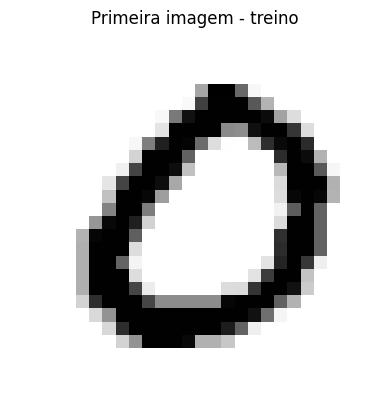

In [8]:
from auxiliary_tools import plot
plot(df_train1.iloc[0], 'Primeira imagem - treino')

#### Visualizando o gráfico com os pontos (intensidade,simetria) de cada label

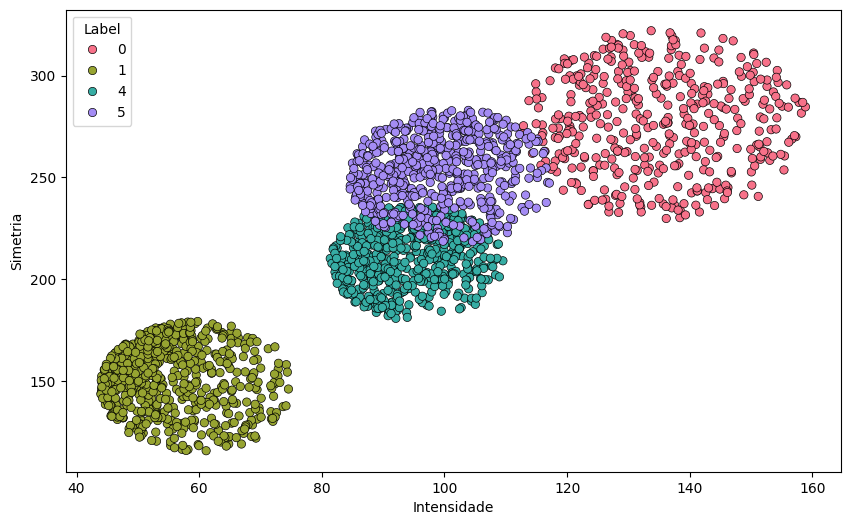

In [12]:
from auxiliary_tools import plot_intensity_vs_symmetry

plot_intensity_vs_symmetry(df_train,save_path='imagens/grafico_int_simetria.png')


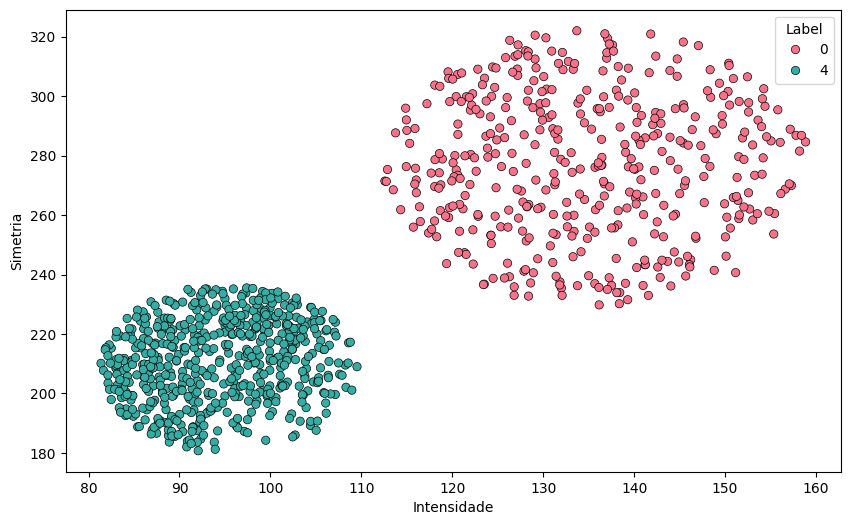

In [14]:
from auxiliary_tools import filter_and_transform_df

filtered_df = filter_and_transform_df(df_train, 0, 4)
filtered_df.head()
plot_intensity_vs_symmetry(filtered_df )

In [15]:
filtered_df.head()

,label,intensidade,simetria,label_to_calculate
0,0,145.435294,297.145098,1
1,0,118.576471,274.227451,1
2,0,127.600000,268.094118,1
3,0,138.047059,302.007843,1
4,0,146.215686,245.003922,1


Percebe-se que nosso w0 (coeficiente linear da reta) é 3.588 e que nosso w1 (coeficiente angular da reta) é -0.019.



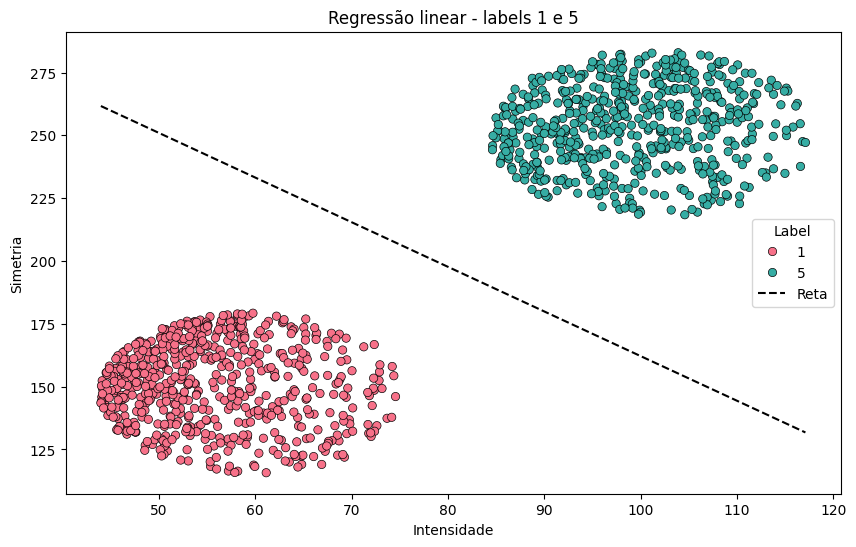

In [16]:
from funcs import LinearRegression

filtered_df = filter_and_transform_df(df_train, 1, 5)
X = filtered_df[['intensidade', 'simetria']]
y = filtered_df['label_to_calculate']
lr = LinearRegression()
lr.fit(X,y)
ws = lr.getW()
print(f'Percebe-se que nosso w0 (coeficiente linear da reta) é {ws[0]:.3f} e que nosso w1 (coeficiente angular da reta) é {ws[1]:.3f}.\n')
plot_intensity_vs_symmetry(filtered_df,weights=ws,title='Regressão linear - labels 1 e 5',save_path='imagens/rl_1_5.png')

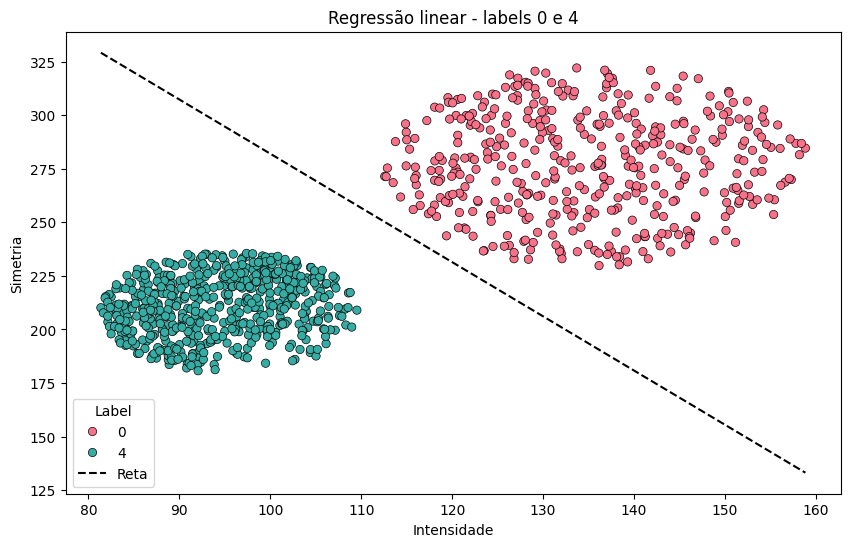

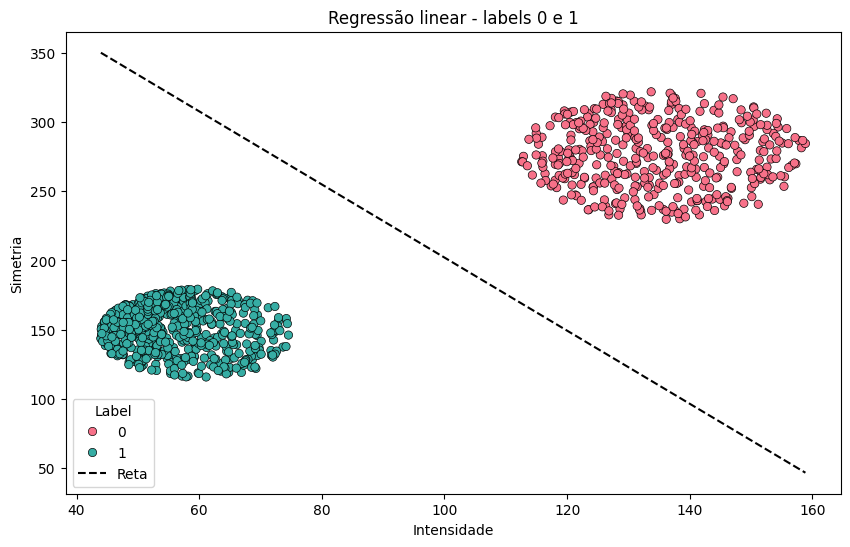

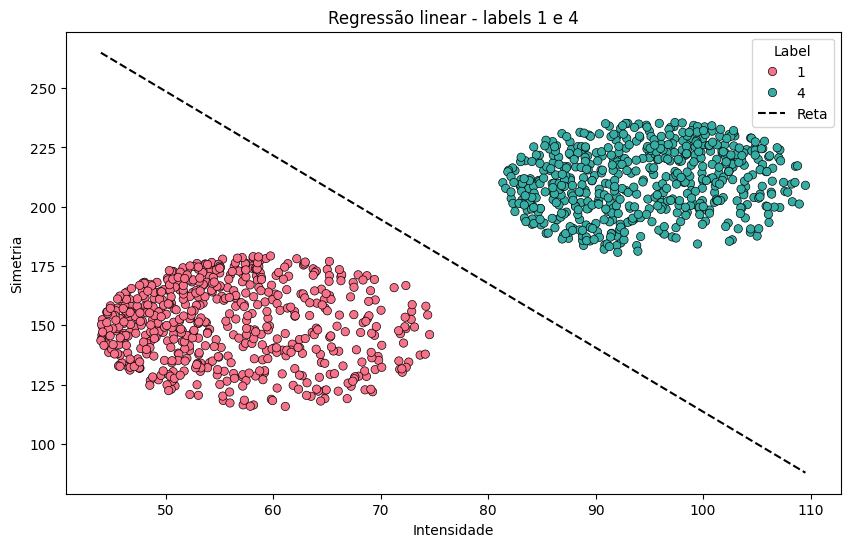

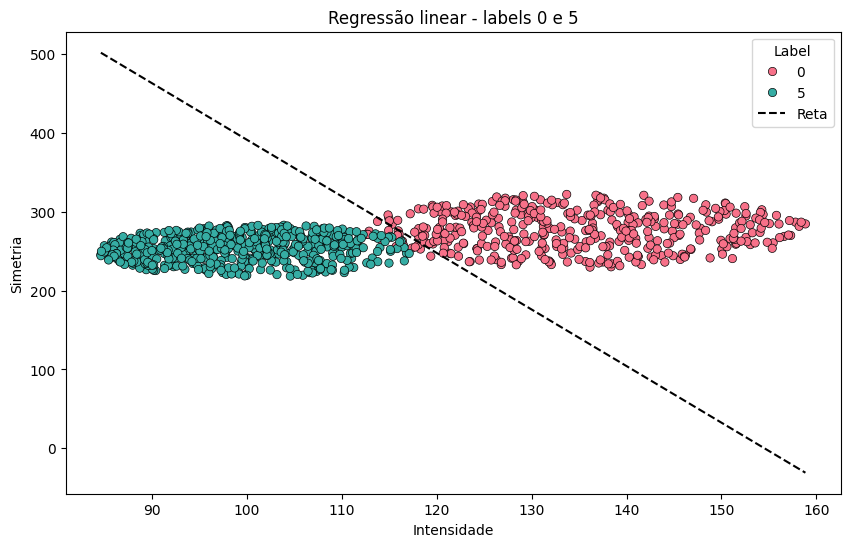

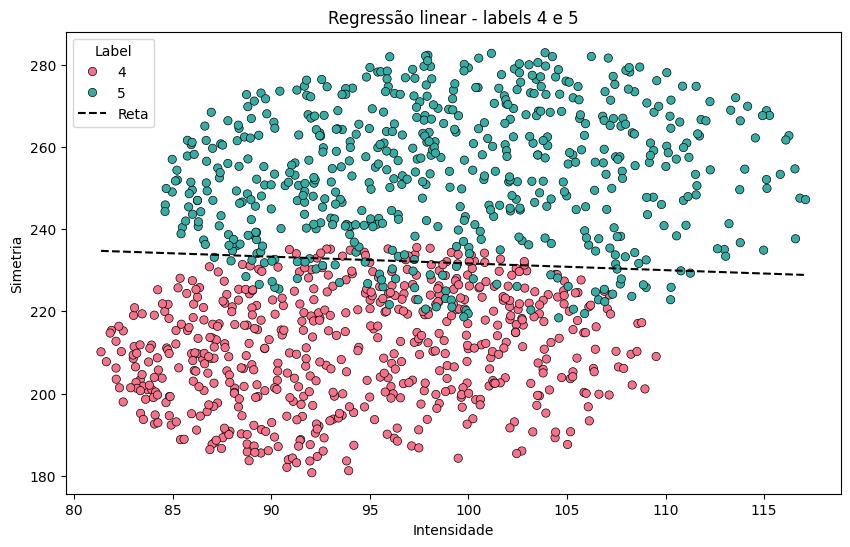

In [18]:
filtered_df = filter_and_transform_df(df_train, 0, 4)
X1 = filtered_df[['intensidade', 'simetria']]
y1 = filtered_df['label_to_calculate']
lr1 = LinearRegression()
lr1.fit(X1,y1)
ws1 = lr1.getW()
plot_intensity_vs_symmetry(filtered_df,weights=ws1,title='Regressão linear - labels 0 e 4',save_path='imagens/rl_0_4.png')

filtered_df = filter_and_transform_df(df_train, 0, 1)
X2= filtered_df[['intensidade', 'simetria']]
y2 = filtered_df['label_to_calculate']
lr2 = LinearRegression()
lr2.fit(X2,y2)
ws2 = lr2.getW()
plot_intensity_vs_symmetry(filtered_df,weights=ws2,title='Regressão linear - labels 0 e 1',save_path='imagens/rl_0_1.png')

filtered_df = filter_and_transform_df(df_train, 1, 4)
X3 = filtered_df[['intensidade', 'simetria']]
y3 = filtered_df['label_to_calculate']
lr3 = LinearRegression()
lr3.fit(X3,y3)
ws3 = lr3.getW()
plot_intensity_vs_symmetry(filtered_df,weights=ws3,title='Regressão linear - labels 1 e 4',save_path='imagens/rl_1_4.png')


filtered_df = filter_and_transform_df(df_train, 0, 5)
X4 = filtered_df[['intensidade', 'simetria']]
y4 = filtered_df['label_to_calculate']
lr4 = LinearRegression()
lr4.fit(X4,y4)
ws4 = lr4.getW()
plot_intensity_vs_symmetry(filtered_df,weights=ws4,title='Regressão linear - labels 0 e 5',save_path='imagens/rl_0_5.png')

filtered_df = filter_and_transform_df(df_train, 4, 5)
X5 = filtered_df[['intensidade', 'simetria']]
y5 = filtered_df['label_to_calculate']
lr5 = LinearRegression()
lr5.fit(X5,y5)
ws4 = lr5.getW()
plot_intensity_vs_symmetry(filtered_df,weights=ws4,title='Regressão linear - labels 4 e 5',save_path='imagens/rl_4_5.png')

In [53]:
from auxiliary_tools import acuracia

filtered_df = filter_and_transform_df(df_teste, 1, 5)
X = filtered_df[['intensidade', 'simetria']]
y = filtered_df['label_to_calculate'].to_numpy()
y_ = np.sign(lr.predict(X))
print(f"Acuracia 1,5: {acuracia(y,y_)}")

filtered_df = filter_and_transform_df(df_teste, 0, 4)
X1 = filtered_df[['intensidade', 'simetria']]
y1 = filtered_df['label_to_calculate'].to_numpy()
y_1 = np.sign(lr1.predict(X1))
print(f"Acuracia 0,4: {acuracia(y1,y_1)}")

filtered_df = filter_and_transform_df(df_teste, 0, 1)
X2 = filtered_df[['intensidade', 'simetria']]
y2 = filtered_df['label_to_calculate'].to_numpy()
y_2 = np.sign(lr2.predict(X2))
print(f"Acuracia 0,1: {acuracia(y2,y_2)}")

filtered_df = filter_and_transform_df(df_teste, 1, 4)
X3 = filtered_df[['intensidade', 'simetria']]
y3 = filtered_df['label_to_calculate'].to_numpy()
y_3 = np.sign(lr3.predict(X3))
print(f"Acuracia 1,4: {acuracia(y3,y_3)}")

filtered_df = filter_and_transform_df(df_teste, 0, 5)
X4 = filtered_df[['intensidade', 'simetria']]
y4 = filtered_df['label_to_calculate'].to_numpy()
y_4 = np.sign(lr4.predict(X4))
print(f"Acuracia 0,5: {acuracia(y4,y_4)}")

filtered_df = filter_and_transform_df(df_teste, 4, 5)
X5 = filtered_df[['intensidade', 'simetria']]
y5 = filtered_df['label_to_calculate'].to_numpy()
y_5 = np.sign(lr5.predict(X5))
print(f"Acuracia 4,5: {acuracia(y5,y_5)}")


Acuracia 1,5: 100.0
Acuracia 0,4: 100.0
Acuracia 0,1: 100.0
Acuracia 1,4: 100.0
Acuracia 0,5: 98.03536345776031
Acuracia 4,5: 94.7107438016529


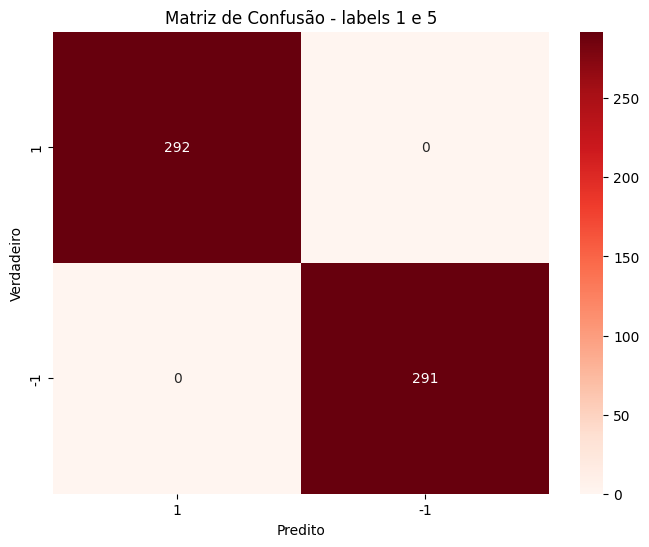

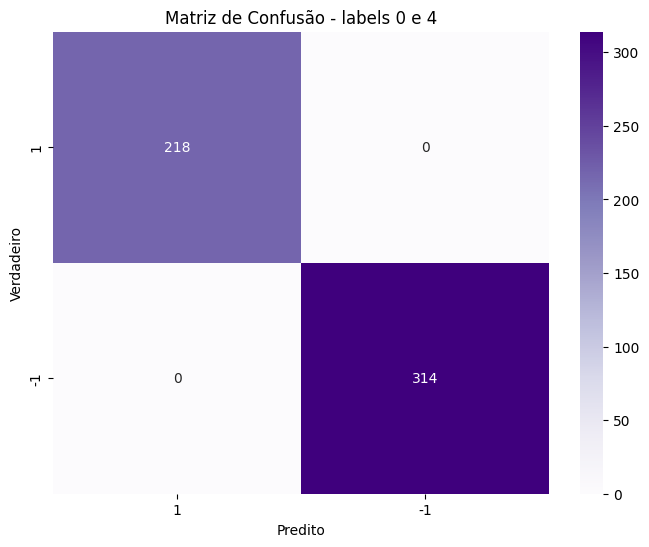

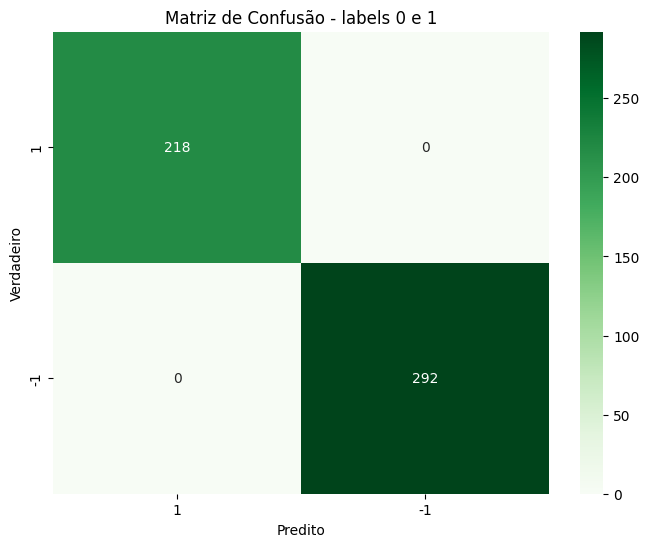

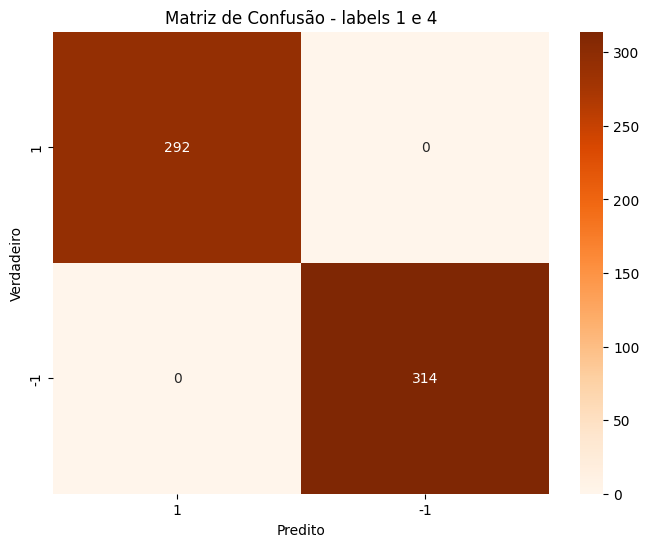

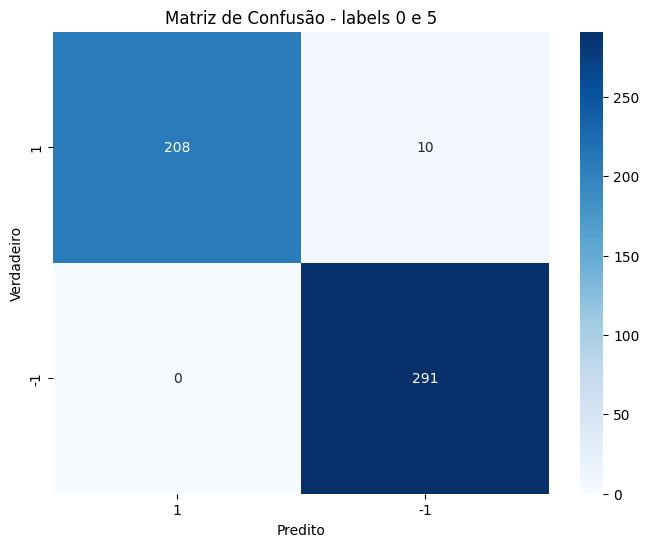

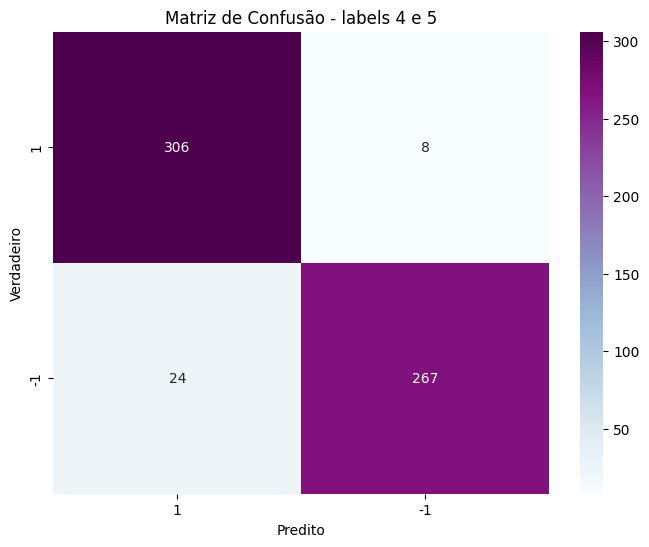

In [60]:
from auxiliary_tools import plot_confusion_matrix

plot_confusion_matrix(y,y_,'Reds',[1,-1],[1,5],'imagens/mc_lr_1_5.png')
plot_confusion_matrix(y1,y_1,'Purples',[1,-1],[0,4],'imagens/mc_lr_0_4.png')
plot_confusion_matrix(y2,y_2,'Greens',[1,-1],[0,1],'imagens/mc_lr_0_1.png')
plot_confusion_matrix(y3,y_3,'Oranges',[1,-1],[1,4],'imagens/mc_lr_1_4.png')
plot_confusion_matrix(y4,y_4,'Blues',[1,-1],[0,5],'imagens/mc_lr_0_5.png')
plot_confusion_matrix(y5,y_5,'BuPu',[1,-1],[4,5],'imagens/mc_lr_4_5.png')


In [20]:
from funcs import Perceptron

filtered_df = filter_and_transform_df(df_train, 0, 1)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y = filtered_df['label_to_calculate'].to_numpy()
p = Perceptron()
it,w = p.fit(X,y)

print("Quantidade de iterações: ", it)
print("Pesos: ", w)

Quantidade de iterações:  119711
Pesos:  [-41085, 1029.9568627448848, -259.9215686273227]


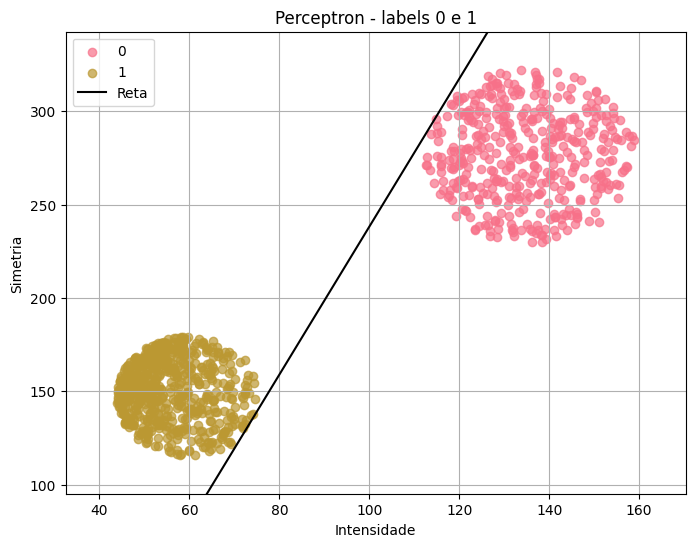

In [21]:
p.plot(X,y,0,1,"imagens/perc_0_1.png","Perceptron - labels 0 e 1")

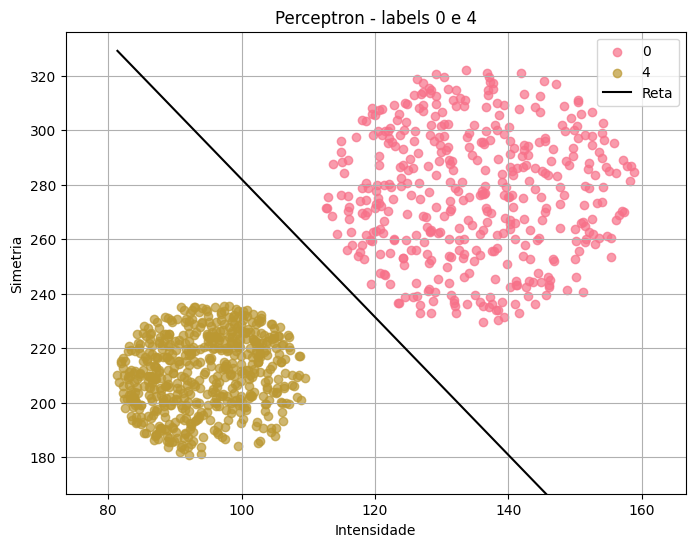

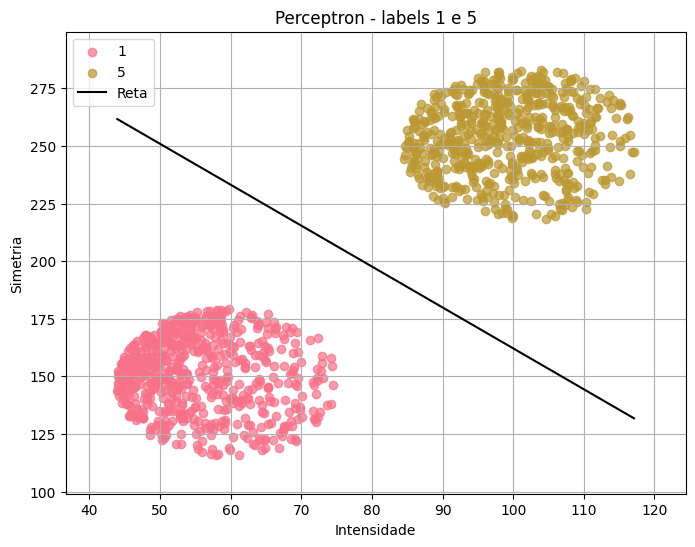

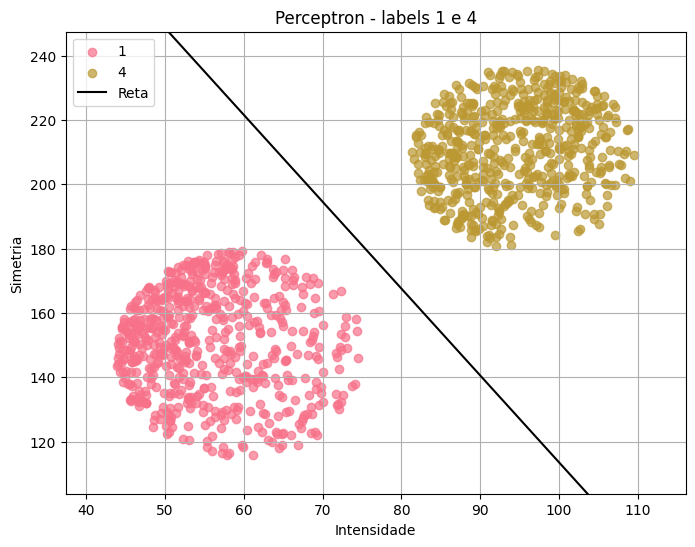

In [22]:
from funcs import Perceptron

filtered_df = filter_and_transform_df(df_train, 0, 4)
X = filtered_df[['intensidade', 'simetria']]
y = filtered_df['label_to_calculate']
lr = LinearRegression()
lr.fit(X,y)
ws1 = lr.getW()
p1 = Perceptron(ws1)
X1 = X.to_numpy()
y1 = y.to_numpy()
it,w = p1.fit(X1,y1)
p1.plot(X1,y1,0,4,"imagens/perc_0_4.png","Perceptron - labels 0 e 4")

filtered_df = filter_and_transform_df(df_train, 1, 5)
X = filtered_df[['intensidade', 'simetria']]
y = filtered_df['label_to_calculate']
lr = LinearRegression()
lr.fit(X,y)
ws1 = lr.getW()
p2 = Perceptron(ws1)
X1 = X.to_numpy()
y1 = y.to_numpy()
it,w = p2.fit(X1,y1)
p2.plot(X1,y1,1,5,"imagens/perc_1_5.png","Perceptron - labels 1 e 5")

filtered_df = filter_and_transform_df(df_train, 1, 4)
X = filtered_df[['intensidade', 'simetria']]
y = filtered_df['label_to_calculate']
lr = LinearRegression()
lr.fit(X,y)
ws1 = lr.getW()
p3 = Perceptron(ws1)
X1 = X.to_numpy()
y1 = y.to_numpy()
it,w = p3.fit(X1,y1)
p3.plot(X1,y1,1,4,"imagens/perc_1_4.png","Perceptron - labels 1 e 4")

#### Acuracia:

In [23]:
from auxiliary_tools import acuracia
filtered_df = filter_and_transform_df(df_teste, 0,1)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y = filtered_df['label_to_calculate'].to_numpy()
results = p.predict(X)
print(f"Acurácia 0 e 1: {acuracia(y,results)}")


filtered_df = filter_and_transform_df(df_teste, 0,4)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y1 = filtered_df['label_to_calculate'].to_numpy()
results1 = p1.predict(X)
print(f"Acurácia 0 e 4: {acuracia(y1,results1)}")

filtered_df = filter_and_transform_df(df_teste, 1,4)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y2 = filtered_df['label_to_calculate'].to_numpy()
results2 = p2.predict(X)
print(f"Acurácia 1 e 4: {acuracia(y2,results2)}")
filtered_df = filter_and_transform_df(df_teste, 1,5)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y3 = filtered_df['label_to_calculate'].to_numpy()
results3 = p3.predict(X)
print(f"Acurácia 1 e 5: {acuracia(y3,results3)}")


Acurácia 0 e 1: 100.0
Acurácia 0 e 4: 100.0
Acurácia 1 e 4: 100.0
Acurácia 1 e 5: 100.0


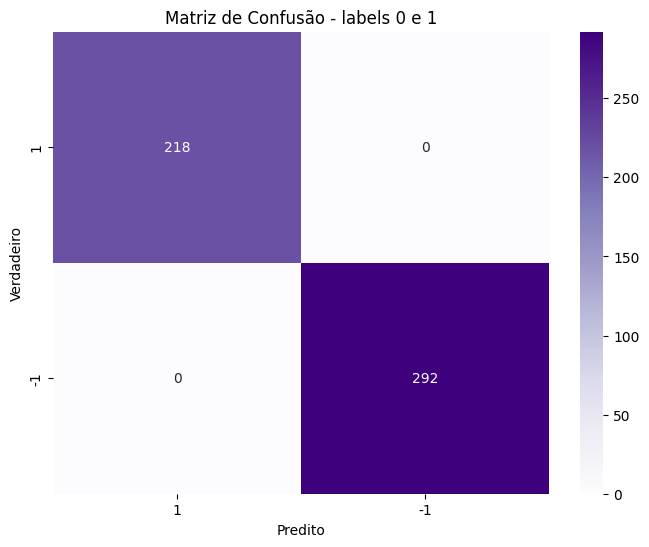

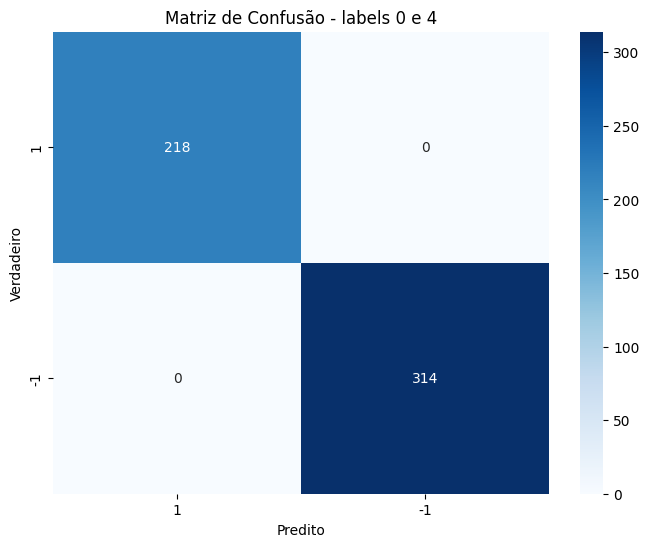

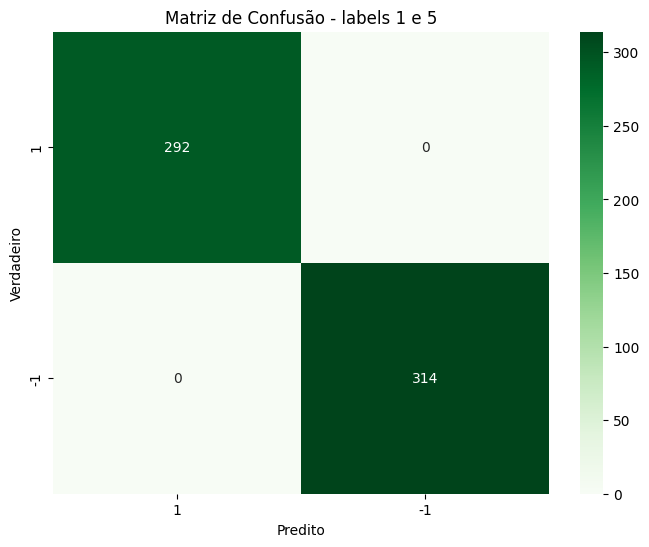

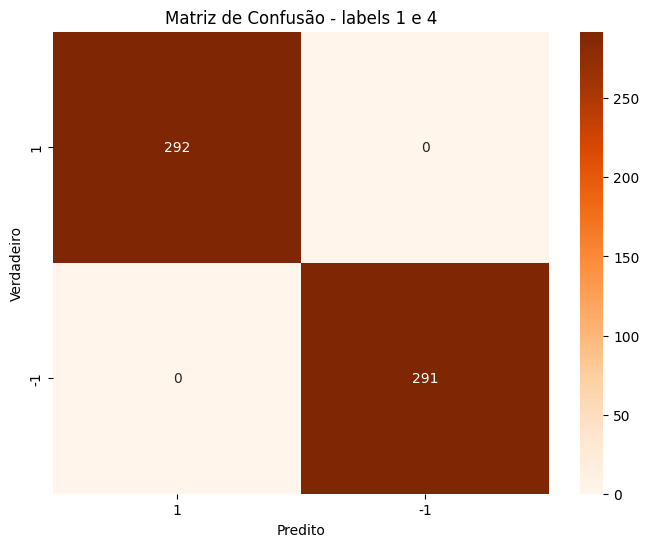

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from auxiliary_tools import plot_confusion_matrix

# Exemplo de uso:
filtered_df = filter_and_transform_df(df_teste, 0, 1)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y = filtered_df['label_to_calculate'].to_numpy()
results = p.predict(X)

# Defina o caminho para salvar a imagem
save_path = 'imagens/mc_perc_0_1.png'

# Plot e salve a matriz de confusão
plot_confusion_matrix(y, results,'Purples', [1, -1],[0,1], save_path=save_path)
plot_confusion_matrix(y1, results1,'Blues', [1, -1],[0,4], save_path='imagens/mc_perc_0_4.png')
plot_confusion_matrix(y2, results2,'Greens', [1, -1],[1,5], save_path='imagens/mc_perc_1_5.png')
plot_confusion_matrix(y3, results3,'Oranges', [1, -1],[1,4], save_path='imagens/mc_perc_1_4.png')



In [ ]:

class Pocket:

  def __init__(self,initial_w = None,it=1000):
    if initial_w is None:
      self.w = [0,0,0]
    else:
      self.w = initial_w
    self.it =  it  

  def constroiListaPCI(self,X, y, w):
      """
      Esta função constrói a lista de pontos classificados incorretamente.

      Paramêtros:
      - X (list[]): Matriz correspondendo aos dados amostra. Cada elemento de X é uma lista que corresponde
      às coordenadas dos pontos gerados.
      - y (list): Classificação dos pontos da amostra X.
      - w (list): Lista correspondendo aos pesos do perceptron.

      Retorno:
      - l (list): Lista com os pontos classificador incorretamente.
      - new_y (list): Nova classificação de tais pontos.

      """
      l = []
      new_y = []
      for i in range(len(X)):
        xi = X[i][0]
        yi = X[i][1]

        new_yi = np.sign(self.w[2]*yi + self.w[1]*xi + self.w[0])
        if (new_yi != y[i]):
          l.append(X[i])
        new_y.append(new_yi)

      return l, new_y

  def fit(self, X, y):
      """
      Esta função corresponde ao Algoritmo de Aprendizagem do modelo Perceptron.

      Paramêtros:
      - X (list[]): Matriz correspondendo aos dados amostra. Cada elemento de X é uma lista que corresponde
      às coordenadas dos pontos gerados.
      - y (list): Classificação dos pontos da amostra X.
      - f (list): Lista de dois elementos correspondendo, respectivamente, aos coeficientes angular e linear
      da função alvo.
      Retorno:
      - it (int): Quantidade de iterações necessárias para corrigir todos os pontos classificados incorretamente.
      - w (list): Lista de três elementos correspondendo aos pesos do perceptron.
      """

      listaPCI,_ = self.constroiListaPCI(X, y, self.w)
      it = 0

      new_y = y
      while (len(listaPCI) > 0):
          numero_aleatorio = random.randint(0, len(listaPCI)-1)
          ponto = listaPCI[numero_aleatorio]


          # Índice do ponto na lista original X
          indice_ponto = np.where((X == ponto).all(axis=1))[0][0]

          # Atualiza os pesos
          self.w[0] += y[indice_ponto]
          self.w[1] += ponto[0] * y[indice_ponto]
          self.w[2] += ponto[1] * y[indice_ponto]



          listaPCI, _ = self.constroiListaPCI(X, new_y, self.w)

          # Após atualizar os pesos para correção do ponto escolhido, você irá chamar a função plotGrafico()
          # plot_grafico(X, y, w, f)
          it+=1

      return it, self.w

  def predict(self,X):
    results = []
    for i in range(len(X)):
        results.append(np.sign(self.w[2]*X[i][1] + self.w[1]*X[i][0] + self.w[0]))
        
    return results
         
  def plot(self, X, y,label1,label2, savepath=None, title='Perceptron - Separação de Classes',scale=1.0):
      """
      Plota os pontos e a linha separadora.

      Parâmetros:
      - X (np.ndarray): Dados de entrada.
      - y (np.ndarray): Rótulos de classe (1 ou -1).
      - savepath (str, opcional): Caminho para salvar o arquivo da figura.
      - title (str, opcional): Título do gráfico.
      - scale (float, opcional): Fator de escala para ajustar o tamanho da imagem.
      """
      X = np.array(X)
      y = np.array(y)
      
      X_pos = X[y == 1]
      X_neg = X[y == -1]
      
      # Definir a paleta de cores 'husl'
      sns.set_palette('husl')
      
      plt.figure(figsize=(8*scale, 6*scale))  # Ajusta o tamanho da figura
      
      plt.scatter(X_pos[:, 0], X_pos[:, 1], color=sns.color_palette()[0], label=label1, alpha=0.7)
      plt.scatter(X_neg[:, 0], X_neg[:, 1], color=sns.color_palette()[1], label=label2, alpha=0.7)
      
      # Coeficientes da reta
      if self.w is not None and len(self.w) > 1:
          x_values = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
          y_values = (-self.w[0] - self.w[1] * x_values) / self.w[2]
          
          plt.plot(x_values, y_values, color='black', label='Reta')
      
      plt.xlabel('Intensidade')
      plt.ylabel('Simetria')
      plt.title(title)
      plt.legend()
      plt.grid(True)
      
      # Ajustar limites dos eixos com base na escala
      x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
      y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
      
      plt.xlim(x_min - (x_max - x_min) * 0.1 * scale, x_max + (x_max - x_min) * 0.1 * scale)
      plt.ylim(y_min - (y_max - y_min) * 0.1 * scale, y_max + (y_max - y_min) * 0.1 * scale)
      
      # Salvar o gráfico se o caminho for fornecido
      if savepath:
          plt.savefig(savepath)
      else:
          plt.show()

#Exemplo de uso:          
"""
filtered_df = filter_and_transform_df(df_train, 0, 1)
X = filtered_df[['intensidade', 'simetria']].to_numpy()
y = filtered_df['label_to_calculate'].to_numpy()
p = Perceptron()
it,w = p.fit(X,y)

print("Quantidade de iterações: ", it)
print("Pesos: ", w)
"""

Obs: acrescentar Viés - Variância